In [1]:
%load_ext autoreload
%autoreload 2

# DataMonitor: Leverage statistics from Datalab to audit new data

Once you've fitted your `Datalab` instance on some training data, it stores some statistics about the training data that may prove useful to monitor new data.
This notebook shows the process of applying Datalab to find issues in training data and then using the same statistics to monitor new data.

This involves a new class called `DataMonitor` that takes a Datalab instance as input to, then run similar issue checks on new data in a more efficient way, especially for
smaller batches of data.


<div class="alert alert-info">
Quickstart
<br/>

Already ran `Datalab` on a dataset? Already have (out-of-sample) `pred_probs` from a model trained on an new set of labels? Some numerical features available for the new data?
Run the code below to examine your dataset for label issues.

<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```ipython3 
from cleanlab.experimental.datalab.data_monitor import DataMonitor

monitor = DataMonitor(datalab=your_datalab)

for batch in new_data_batches:
    # Process data to get labels and predicted probabilities
    your_labels = get_your_labels(batch)
    your_pred_probs = get_pred_probs(batch)
    your_features = get_features(batch)
    
    # Find issues in the batch
    monitor.find_issues(labels=your_labels, pred_probs=your_pred_probs, features=your_features)
```
   
</div>
</div>

## 1. Install and import required dependencies

You can use pip to install all packages required for this tutorial as follows:

```ipython3
!pip install matplotlib
!pip install "cleanlab[datalab]"

# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install git+https://github.com/cleanlab/cleanlab.git
```

In [2]:
# Package installation (hidden on docs website).
dependencies = ["cleanlab", "matplotlib", "datasets"]  # TODO: make sure this list is updated

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install git+https://github.com/elisno/cleanlab.git@75a9d1c1b9619810a274c70287e00e6f0268cfb5
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    dependencies_test = [dependency.split('>')[0] if '>' in dependency 
                         else dependency.split('<')[0] if '<' in dependency 
                         else dependency.split('=')[0] for dependency in dependencies]
    missing_dependencies = []
    for dependency in dependencies_test:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

In [3]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

from cleanlab import Datalab
from cleanlab.experimental.datalab.data_monitor import DataMonitor

## 2. Create and load the data (can skip these details)

For this tutorial, we'll re-use the toy classification dataset from the `Datalab` quickstart tutorial. The dataset has two numerical features and a label column with three possible classes. Each example is classified as either: *low*, *mid* or *high*.

Here we show a workflow for finding label issues on data unseen by `Datalab` using the `DataMonitor` class.

<details><summary>See the code for data generation. **(click to expand)**</summary>
    
```ipython3
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

from sklearn.model_selection import train_test_split
from cleanlab.benchmarking.noise_generation import (
    generate_noise_matrix_from_trace,
    generate_noisy_labels,
)

SEED = 123
np.random.seed(SEED)

BINS = {
    "low": [-np.inf, 3.3],
    "mid": [3.3, 6.6],
    "high": [6.6, +np.inf],
}

BINS_MAP = {
    "low": 0,
    "mid": 1,
    "high": 2,
}


def create_data():

    X = np.random.rand(800, 2) * 5
    y = np.sum(X, axis=1)
    # Map y to bins based on the BINS dict
    y_bin = np.array([k for y_i in y for k, v in BINS.items() if v[0] <= y_i < v[1]])
    y_bin_idx = np.array([BINS_MAP[k] for k in y_bin])

    # Split into train and test
    X_train, X_test, y_train, y_test, y_train_idx, y_test_idx = train_test_split(
        X, y_bin, y_bin_idx, test_size=0.1, random_state=SEED
    )

    # Add several (5) out-of-distribution points. Sliding them along the decision boundaries
    # to make them look like they are out-of-frame
    X_out = np.array(
        [
            [-1.5, 3.0],
            [-1.75, 6.5],
            [1.5, 7.2],
            [2.5, -2.0],
            [5.5, 7.0],
        ]
    )
    # Add a near duplicate point to the last outlier, with some tiny noise added
    near_duplicate = X_out[-1:] + np.random.rand(1, 2) * 1e-6
    X_out = np.concatenate([X_out, near_duplicate])

    y_out = np.sum(X_out, axis=1)
    y_out_bin = np.array([k for y_i in y_out for k, v in BINS.items() if v[0] <= y_i < v[1]])
    y_out_bin_idx = np.array([BINS_MAP[k] for k in y_out_bin])

    # Add to train
    X_train = np.concatenate([X_train, X_out])
    y_train = np.concatenate([y_train, y_out])
    y_train_idx = np.concatenate([y_train_idx, y_out_bin_idx])

    # Add an exact duplicate example to the training set
    exact_duplicate_idx = np.random.randint(0, len(X_train))
    X_duplicate = X_train[exact_duplicate_idx, None]
    y_duplicate = y_train[exact_duplicate_idx, None]
    y_duplicate_idx = y_train_idx[exact_duplicate_idx, None]

    # Add to train
    X_train = np.concatenate([X_train, X_duplicate])
    y_train = np.concatenate([y_train, y_duplicate])
    y_train_idx = np.concatenate([y_train_idx, y_duplicate_idx])

    py = np.bincount(y_train_idx) / float(len(y_train_idx))
    m = len(BINS)

    noise_matrix = generate_noise_matrix_from_trace(
        m,
        trace=0.9 * m,
        py=py,
        valid_noise_matrix=True,
        seed=SEED,
    )

    noisy_labels_idx = generate_noisy_labels(y_train_idx, noise_matrix)
    noisy_labels = np.array([list(BINS_MAP.keys())[i] for i in noisy_labels_idx])

    return X_train, y_train_idx, noisy_labels, noisy_labels_idx, X_out, X_duplicate
```

</details>

In [4]:
from sklearn.model_selection import train_test_split
from cleanlab.benchmarking.noise_generation import (
    generate_noise_matrix_from_trace,
    generate_noisy_labels,
)

SEED = 123
np.random.seed(SEED)

BINS = {
    "low": [-np.inf, 3.3],
    "mid": [3.3, 6.6],
    "high": [6.6, +np.inf],
}

BINS_MAP = {
    "low": 0,
    "mid": 1,
    "high": 2,
}


def create_data():

    X = np.random.rand(800, 2) * 5
    y = np.sum(X, axis=1)
    # Map y to bins based on the BINS dict
    y_bin = np.array([k for y_i in y for k, v in BINS.items() if v[0] <= y_i < v[1]])
    y_bin_idx = np.array([BINS_MAP[k] for k in y_bin])

    # Split into train and test
    X_train, X_test, y_train, y_test, y_train_idx, y_test_idx = train_test_split(
        X, y_bin, y_bin_idx, test_size=0.1, random_state=SEED
    )

    # Add several (5) out-of-distribution points. Sliding them along the decision boundaries
    # to make them look like they are out-of-frame
    X_out = np.array(
        [
            [-1.5, 3.0],
            [-1.75, 6.5],
            [1.5, 7.2],
            [2.5, -2.0],
            [5.5, 7.0],
        ]
    )
    # Add a near duplicate point to the last outlier, with some tiny noise added
    near_duplicate = X_out[-1:] + np.random.rand(1, 2) * 1e-6
    X_out = np.concatenate([X_out, near_duplicate])

    y_out = np.sum(X_out, axis=1)
    y_out_bin = np.array([k for y_i in y_out for k, v in BINS.items() if v[0] <= y_i < v[1]])
    y_out_bin_idx = np.array([BINS_MAP[k] for k in y_out_bin])

    # Add to train
    X_train = np.concatenate([X_train, X_out])
    y_train = np.concatenate([y_train, y_out])
    y_train_idx = np.concatenate([y_train_idx, y_out_bin_idx])

    # Add an exact duplicate example to the training set
    exact_duplicate_idx = np.random.randint(0, len(X_train))
    X_duplicate = X_train[exact_duplicate_idx, None]
    y_duplicate = y_train[exact_duplicate_idx, None]
    y_duplicate_idx = y_train_idx[exact_duplicate_idx, None]

    # Add to train
    X_train = np.concatenate([X_train, X_duplicate])
    y_train = np.concatenate([y_train, y_duplicate])
    y_train_idx = np.concatenate([y_train_idx, y_duplicate_idx])

    py = np.bincount(y_train_idx) / float(len(y_train_idx))
    m = len(BINS)

    noise_matrix = generate_noise_matrix_from_trace(
        m,
        trace=0.9 * m,
        py=py,
        valid_noise_matrix=True,
        seed=SEED,
    )

    noisy_labels_idx = generate_noisy_labels(y_train_idx, noise_matrix)
    noisy_labels = np.array([list(BINS_MAP.keys())[i] for i in noisy_labels_idx])

    return X_train, y_train_idx, noisy_labels, noisy_labels_idx, X_out, X_duplicate

In [5]:
X_train, y_train_idx, noisy_labels, noisy_labels_idx, X_out, X_duplicate = create_data()

In [6]:
train_X, test_X, train_y_true, test_y_true, train_y, test_y, train_y_idx, test_y_idx = train_test_split(X_train, y_train_idx, noisy_labels, noisy_labels_idx, test_size=400, random_state=SEED)
data = {"X": train_X, "y": train_y}
test_data = {"X": test_X, "y": test_y}

We make a scatter plot of the features, with a color corresponding to the observed labels. Incorrect given labels are highlighted in red if they do not match the true label, outliers highlighted with an a black cross, and duplicates highlighted with a cyan cross.

<details><summary>See the code to visualize the data. **(click to expand)**</summary>
    
```ipython3
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

import matplotlib.pyplot as plt

def plot_data(X_train, y_train_idx, noisy_labels_idx):
    # Plot data with clean labels and noisy labels, use BINS_MAP for the legend
    fig, ax = plt.subplots(figsize=(6, 4))
        
    low = ax.scatter(X_train[noisy_labels_idx == 0, 0], X_train[noisy_labels_idx == 0, 1], label="low")
    mid = ax.scatter(X_train[noisy_labels_idx == 1, 0], X_train[noisy_labels_idx == 1, 1], label="mid")
    high = ax.scatter(X_train[noisy_labels_idx == 2, 0], X_train[noisy_labels_idx == 2, 1], label="high")
    
    ax.set_title("Noisy labels")
    ax.set_xlabel(r"$x_1$", fontsize=16)
    ax.set_ylabel(r"$x_2$", fontsize=16)

    # Plot true boundaries (x+y=3.3, x+y=6.6)
    ax.set_xlim(-2.5, 8.5)
    ax.set_ylim(-3.5, 9.0)
    ax.plot([-0.7, 4.0], [4.0, -0.7], color="k", linestyle="--", alpha=0.5)
    ax.plot([-0.7, 7.3], [7.3, -0.7], color="k", linestyle="--", alpha=0.5)

    # Draw red circles around the points that are misclassified (i.e. the points that are in the wrong bin)
    for i, (X, y) in enumerate(zip([X_train, X_train], [y_train_idx, noisy_labels_idx])):
        for j, (k, v) in enumerate(BINS_MAP.items()):
            label_err = ax.scatter(
                X[(y == v) & (y != y_train_idx), 0],
                X[(y == v) & (y != y_train_idx), 1],
                s=180,
                marker="o",
                facecolor="none",
                edgecolors="red",
                linewidths=2.5,
                alpha=0.5,
                label="Label error",
            )
    
    title_fontproperties = {"weight":"semibold", "size": 8}
    first_legend = ax.legend(handles=[low, mid, high], loc=[0.76, 0.7], title="Given Class Label", alignment="left", title_fontproperties=title_fontproperties, fontsize=8, markerscale=0.5)
    second_legend = ax.legend(handles=[label_err], loc=[0.76, 0.46], title="Type of Issue", alignment="left", title_fontproperties=title_fontproperties, fontsize=8, markerscale=0.5)
    
    ax = plt.gca().add_artist(first_legend)
    ax = plt.gca().add_artist(second_legend)
    plt.tight_layout()
```
    
</details>

In [7]:
import matplotlib.pyplot as plt

def plot_data(X_train, y_train_idx, noisy_labels_idx):
    # Plot data with clean labels and noisy labels, use BINS_MAP for the legend
    fig, ax = plt.subplots(figsize=(6, 4))
        
    low = ax.scatter(X_train[noisy_labels_idx == 0, 0], X_train[noisy_labels_idx == 0, 1], label="low")
    mid = ax.scatter(X_train[noisy_labels_idx == 1, 0], X_train[noisy_labels_idx == 1, 1], label="mid")
    high = ax.scatter(X_train[noisy_labels_idx == 2, 0], X_train[noisy_labels_idx == 2, 1], label="high")
    
    ax.set_title("Noisy labels")
    ax.set_xlabel(r"$x_1$", fontsize=16)
    ax.set_ylabel(r"$x_2$", fontsize=16)

    # Plot true boundaries (x+y=3.3, x+y=6.6)
    ax.set_xlim(-2.5, 8.5)
    ax.set_ylim(-3.5, 9.0)
    ax.plot([-0.7, 4.0], [4.0, -0.7], color="k", linestyle="--", alpha=0.5)
    ax.plot([-0.7, 7.3], [7.3, -0.7], color="k", linestyle="--", alpha=0.5)

    # Draw red circles around the points that are misclassified (i.e. the points that are in the wrong bin)
    for i, (X, y) in enumerate(zip([X_train, X_train], [y_train_idx, noisy_labels_idx])):
        for j, (k, v) in enumerate(BINS_MAP.items()):
            label_err = ax.scatter(
                X[(y == v) & (y != y_train_idx), 0],
                X[(y == v) & (y != y_train_idx), 1],
                s=180,
                marker="o",
                facecolor="none",
                edgecolors="red",
                linewidths=2.5,
                alpha=0.5,
                label="Label error",
            )
    
    title_fontproperties = {"weight":"semibold", "size": 8}
    first_legend = ax.legend(handles=[low, mid, high], loc=[0.76, 0.7], title="Given Class Label", alignment="left", title_fontproperties=title_fontproperties, fontsize=8, markerscale=0.5)
    second_legend = ax.legend(handles=[label_err], loc=[0.76, 0.46], title="Type of Issue", alignment="left", title_fontproperties=title_fontproperties, fontsize=8, markerscale=0.5)
    
    ax = plt.gca().add_artist(first_legend)
    ax = plt.gca().add_artist(second_legend)
    plt.tight_layout()

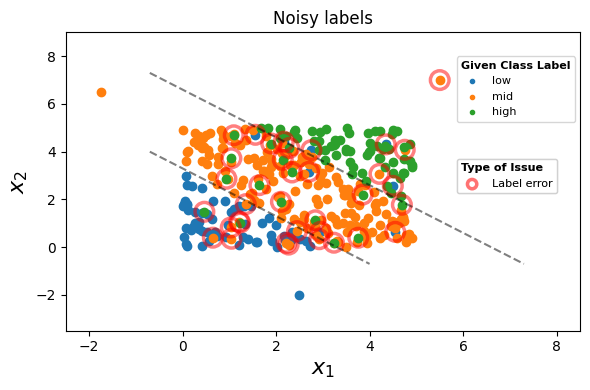

In [8]:
plot_data(train_X, train_y_true, train_y_idx)

## 3. Get out-of-sample predicted probabilities from a classifier

To detect certain types of issues in classification data (e.g. label errors), `Datalab` and `DataMonitor` rely on predicted class probabilities from a trained model. Ideally, the prediction for each example should be out-of-sample (to avoid overfitting), coming from a copy of the model that was not trained on this example. 


Similar to what is shown in the `Datalab` quickstart tutorial, this tutorial uses a simple logistic regression model 
and the `cross_val_predict()` function from scikit-learn to generate out-of-sample predicted class probabilities for every example in the training set. You can replace this with *any* other classifier model and train it with cross-validation to get out-of-sample predictions.
Make sure that the columns of your `pred_probs` are properly ordered with respect to the ordering of classes, which for Datalab is: lexicographically sorted by class name.

In [9]:
model = LogisticRegression()
pred_probs = cross_val_predict(
    estimator=model, X=train_X, y=train_y, cv=5, method="predict_proba",
)

## 4. Use Datalab to find issues in the dataset

These steps are pretty much identical to the `Datalab` quickstart tutorial. We'll use the `Datalab` class to find issues in the training data.

In [10]:
lab = Datalab(data=data, label_name="y", task="classification")

# For simplicity, let's leverage the cross-validated predicted probabilities to find possible label issues
lab.find_issues(pred_probs=pred_probs, issue_types={"label": {}})

lab.report()

Finding label issues ...



Audit complete. 29 issues found in the dataset.
Here is a summary of the different kinds of issues found in the data:

issue_type  num_issues
     label          29

Dataset Information: num_examples: 327, num_classes: 3


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having label issues.
    

Number of examples with this issue: 29
Overall dataset quality in terms of this issue: 0.9297

Examples representing most severe instances of this issue:
     is_label_issue  label_score given_label predicted_label
53             True     0.000124         low            high
259            True     0.000725        high             low
269            True     0.000794         mid            high
89             True     0.002061        high             low
125           False     0.002908         low             mid


Great! The `Datalab` instance has seen some training data and found some issues. This would be a good time to look at any major issues that may be easily resolved. For example, if there are many label errors of a certain class, you may want to investigate why this is happening and fix the issue at the source.



## 5. Use DataMonitor to find issues in new data



Now, how do you monitor new data for the same issues? You pass the `Datalab` instance to the `DataMonitor` class, which can then be used to monitor new data for the same issues.

In [11]:
# Set up the data monitor
monitor = DataMonitor(datalab=lab)

For new data, you may be running model predictions on-the-fly and want to monitor the predictions for issues. 
This requires a slightly different approach than the one used for training data, when feeding the data in batches to the DataMonitor.

Here, we'll simulate a stream of data points annotated with some given labels and some model predictions. We'll then use the `DataMonitor` class to monitor the data stream for issues.

Generally, you would have a model already trained on the full training data and would be running predictions on new data.

In [12]:
from tqdm.auto import tqdm
from time import sleep

# Fit a classification model on the full training set
model = LogisticRegression()
model.fit(train_X, lab.labels)


# Here, we simulate a streaming scenario by processing some of test data, 1 sample at a time
batch_size = 1
def generate_stream(data: dict, batch_size=1, sleep_time=0.1):
    n = len(next(iter(data.values())))
    for i in tqdm(range(0, n, batch_size), total=n // batch_size, desc=f"Streaming data, {batch_size} sample(s) at a time"):
        batch = {k: v[i:i + batch_size] for k, v in data.items()}
        
        # Simulate some processing time
        sleep(sleep_time)
          
        yield {"labels": batch["y"], "pred_probs": model.predict_proba(batch["X"])}

singleton_stream = generate_stream({"X": test_X[:50], "y": test_y[:50]})
# TODO: Add seamless Singleton Support designed to intuitively
# handle single data points without requiring the user to wrap singletons in additional data structures

batched_stream = generate_stream({"X": test_X[50:], "y": test_y[50:]}, batch_size=50, sleep_time=0.75)

In [13]:
# Process a stream of data to provide the necessary arguments for the find_issues method
for processed_singleton in singleton_stream:
    monitor.find_issues(**processed_singleton)

Streaming data, 1 sample(s) at a time:   0%|          | 0/50 [00:00<?, ?it/s]

Detected issues in the current batch:
     is_label_issue  label_score given_label suggested_label
10            True     0.250997        high             mid 



Detected issues in the current batch:
     is_label_issue  label_score given_label suggested_label
25            True     0.285757         mid            high 



Detected issues in the current batch:
     is_label_issue  label_score given_label suggested_label
43            True     0.120906         low             mid 



The same principle works for larger batches of data, but the main idea is to not exceed the memory limits of the system by loading the entire dataset at once.

In [14]:
for processed_batch in batched_stream:
    monitor.find_issues(**processed_batch)

Streaming data, 50 sample(s) at a time:   0%|          | 0/7 [00:00<?, ?it/s]

Detected issues in the current batch:
     is_label_issue  label_score given_label suggested_label
51            True     0.002748        high             low
75            True     0.189996         mid             low 



Detected issues in the current batch:
      is_label_issue  label_score given_label suggested_label
121            True     0.093505        high             mid
123            True     0.037250        high             mid
149            True     0.076397        high             mid 



Detected issues in the current batch:
      is_label_issue  label_score given_label suggested_label
154            True     0.294010         mid             low
160            True     0.073622         low             mid
166            True     0.140832         mid             low
167            True     0.041743        high             mid
181            True     0.169429        high             mid 



Detected issues in the current batch:
      is_label_issue  label_score given_label suggested_label
200            True     0.127304         low             mid
235            True     0.090310        high             mid 



Detected issues in the current batch:
      is_label_issue  label_score given_label suggested_label
254            True     0.183343        high             mid
256            True     0.048720        high             mid
263            True     0.138820         mid            high
292            True     0.239609        high             mid
295            True     0.022075        high             mid 



Detected issues in the current batch:
      is_label_issue  label_score given_label suggested_label
306            True     0.103040        high             mid
343            True     0.234755        high             mid 



Detected issues in the current batch:
      is_label_issue  label_score given_label suggested_label
354            True     0.001612         low            high
359            True     0.068359         low             mid
367            True     0.015793        high             mid
368            True     0.029022        high             mid
391            True     0.106761         low             mid 



The `DataMonitor` keeps track of the issue masks and issue scores for each data point that is streamed through it. During the call to `DataMonitor.find_issues`, any time an issue is found, it prints out the troublesome data points in the batch, along with the issue type and score.

## 6. Learn more about the issues in the additional data

TODO

The data monitor has several properties that allow you to inspect the results of
the full monitoring process.

In [15]:
# View the full issues dataframe (analogous to the Datalab.issues DataFrame)
display(monitor.issues)

# Look at particular issue types
# TODO
# monitor.get_issues("label")
monitor.issues.sort_values("label_score")

,is_label_issue,label_score
0,False,0.623844
1,False,0.812647
2,False,0.816854
3,False,0.661968
4,False,0.632244
...,...,...
395,False,0.474599
396,False,0.653901
397,False,0.584554
398,False,0.817287


,is_label_issue,label_score
354,True,0.001612
51,True,0.002748
367,True,0.015793
295,True,0.022075
368,True,0.029022
...,...,...
183,False,0.937927
309,False,0.939505
133,False,0.947290
177,False,0.952187


In [16]:
# Look at a summary of all the issue checks across the full monitoring process
monitor.issue_summary

# TODO: Align the behavior of the DataMonitor.issue_summary with the Datalab.get_issue_summary method 

,issue_type,num_issues,score
0,label,27,0.655501


## 7. Finding outliers in new data

In [17]:
lab = Datalab(data=data)

lab.find_issues(features=data["X"], issue_types={"outlier": {}})

lab.report()

Finding outlier issues ...
Fitting OOD estimator based on provided features ...

Audit complete. 6 issues found in the dataset.
Here is a summary of the different kinds of issues found in the data:

issue_type  num_issues
   outlier           6

Dataset Information: num_examples: 327


---------------------- outlier issues ----------------------

About this issue:
	Examples that are very different from the rest of the dataset 
    (i.e. potentially out-of-distribution or rare/anomalous instances).
    

Number of examples with this issue: 6
Overall dataset quality in terms of this issue: 0.3603

Examples representing most severe instances of this issue:
     is_outlier_issue  outlier_score
173              True       0.000330
269              True       0.000626
296              True       0.002004
304              True       0.165496
275              True       0.179811


In [18]:
# Set up the data monitor
monitor = DataMonitor(datalab=lab)

In [19]:
# Here, we simulate a streaming scenario by processing some of test data, 1 sample at a time
batch_size = 1
def generate_stream(data: dict, batch_size=1, sleep_time=0.1):
    n = len(next(iter(data.values())))
    for i in tqdm(range(0, n, batch_size), total=n // batch_size, desc=f"Streaming data, {batch_size} sample(s) at a time"):
        batch = {k: v[i:i + batch_size] for k, v in data.items()}
        
        # Simulate some processing time
        sleep(sleep_time)
          
        yield {"features": batch["X"]}

singleton_stream = generate_stream({"X": test_X[:50]})
# TODO: Add seamless Singleton Support designed to intuitively
# handle single data points without requiring the user to wrap singletons in additional data structures

batched_stream = generate_stream({"X": test_X[50:]}, batch_size=50, sleep_time=0.75)

In [20]:
# Process a stream of data to provide the necessary arguments for the find_issues method
for processed_singleton in singleton_stream:
    monitor.find_issues(**processed_singleton)

for processed_batch in batched_stream:
    monitor.find_issues(**processed_batch)

Streaming data, 1 sample(s) at a time:   0%|          | 0/50 [00:00<?, ?it/s]

Detected issues in the current batch:
     is_outlier_issue  outlier_score
15              True       0.001317 



Streaming data, 50 sample(s) at a time:   0%|          | 0/7 [00:00<?, ?it/s]

Detected issues in the current batch:
      is_outlier_issue  outlier_score
166              True       0.005943 



Detected issues in the current batch:
      is_outlier_issue  outlier_score
314              True       0.001426
320              True       0.186355
349              True       0.187305 



Detected issues in the current batch:
      is_outlier_issue  outlier_score
393              True       0.169838
395              True       0.185770 



## 8. Looking for both label issues and outliers

In [21]:
lab = Datalab(data=data, label_name="y", task="classification")

lab.find_issues(features=data["X"], pred_probs=pred_probs, issue_types={"outlier": {}, "label": {}})

lab.report()

Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding label issues ...



Audit complete. 35 issues found in the dataset.
Here is a summary of the different kinds of issues found in the data:

issue_type  num_issues
     label          29
   outlier           6

Dataset Information: num_examples: 327, num_classes: 3


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having label issues.
    

Number of examples with this issue: 29
Overall dataset quality in terms of this issue: 0.9297

Examples representing most severe instances of this issue:
     is_label_issue  label_score given_label predicted_label
53             True     0.000124         low            high
259            True     0.000725        high             low
269            True     0.000794         mid            high
89             True     0.002061        high             low
125           False     0.002908         low             mid


-----

In [22]:
monitor = DataMonitor(datalab=lab)

In [23]:
# Here, we simulate a streaming scenario by processing some of test data, 1 sample at a time
batch_size = 1
def generate_stream(data: dict, batch_size=1, sleep_time=0.1):
    n = len(next(iter(data.values())))
    for i in tqdm(range(0, n, batch_size), total=n // batch_size, desc=f"Streaming data, {batch_size} sample(s) at a time"):
        batch = {k: v[i:i + batch_size] for k, v in data.items()}
        
        # Simulate some processing time
        sleep(sleep_time)
          
        yield {"features": batch["X"], "labels": batch["y"], "pred_probs": model.predict_proba(batch["X"])}

singleton_stream = generate_stream({"X": test_X[:50], "y": test_y[:50]})
# TODO: Add seamless Singleton Support designed to intuitively
# handle single data points without requiring the user to wrap singletons in additional data structures

batched_stream = generate_stream({"X": test_X[50:], "y": test_y[50:]}, batch_size=50, sleep_time=0.75)

In [24]:
# Process a stream of data to provide the necessary arguments for the find_issues method
for processed_singleton in singleton_stream:
    monitor.find_issues(**processed_singleton)

for processed_batch in batched_stream:
    monitor.find_issues(**processed_batch)

Streaming data, 1 sample(s) at a time:   0%|          | 0/50 [00:00<?, ?it/s]

Detected issues in the current batch:
     is_label_issue  label_score given_label suggested_label
10            True     0.250997        high             mid 



Detected issues in the current batch:
     is_outlier_issue  outlier_score
15              True       0.001317 



Detected issues in the current batch:
     is_label_issue  label_score given_label suggested_label
25            True     0.285757         mid            high 



Detected issues in the current batch:
     is_label_issue  label_score given_label suggested_label
43            True     0.120906         low             mid 



Streaming data, 50 sample(s) at a time:   0%|          | 0/7 [00:00<?, ?it/s]

Detected issues in the current batch:
     is_label_issue  label_score given_label suggested_label
51            True     0.002748        high             low
75            True     0.189996         mid             low 



Detected issues in the current batch:
      is_label_issue  label_score given_label suggested_label
121            True     0.093505        high             mid
123            True     0.037250        high             mid
149            True     0.076397        high             mid 



Detected issues in the current batch:
      is_label_issue  label_score  is_outlier_issue  outlier_score given_label suggested_label
154            True     0.294010             False       0.369889         mid             low
160            True     0.073622             False       0.285297         low             mid
166            True     0.140832              True       0.005943         mid             low
167            True     0.041743             False       0.406162        high             mid
181            True     0.169429             False       0.516543        high             mid 



Detected issues in the current batch:
      is_label_issue  label_score given_label suggested_label
200            True     0.127304         low             mid
235            True     0.090310        high             mid 



Detected issues in the current batch:
      is_label_issue  label_score given_label suggested_label
254            True     0.183343        high             mid
256            True     0.048720        high             mid
263            True     0.138820         mid            high
292            True     0.239609        high             mid
295            True     0.022075        high             mid 



Detected issues in the current batch:
      is_label_issue  label_score  is_outlier_issue  outlier_score given_label suggested_label
306            True     0.103040             False       0.440142        high             mid
314           False     0.997293              True       0.001426        high            high
320           False     0.476283              True       0.186355        high             mid
343            True     0.234755             False       0.382757        high             mid
349           False     0.466786              True       0.187305        high             mid 



Detected issues in the current batch:
      is_label_issue  label_score  is_outlier_issue  outlier_score given_label suggested_label
354            True     0.001612             False       0.522078         low            high
359            True     0.068359             False       0.276298         low             mid
367            True     0.015793             False       0.328181        high             mid
368            True     0.029022             False       0.409633        high             mid
391            True     0.106761             False       0.281425         low             mid
393           False     0.518102              True       0.169838        high            high
395           False     0.474599              True       0.185770        high             mid 



In [25]:
monitor.issue_summary

,issue_type,num_issues,score
0,label,27,0.655501
1,outlier,7,0.360596
